# Prepare Few-Shot Examples from Local CholecSeg8k Dataset

This notebook finds few-shot examples for both pointing and bounding box tasks using the local dataset adapter.

In [1]:
import sys
import os
import json
import numpy as np
import torch
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import defaultdict
import random
from scipy import ndimage

# Add src to path
sys.path.insert(0, '/shared_data0/weiqiuy/llm_cholec_organ/src')

# Import our modules
from endopoint.datasets import build_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

print("✓ Modules imported")

✓ Modules imported


## Configuration

In [2]:
CONFIG = {
    "n_test_samples": 100,  # Number of balanced test samples
    "n_pos_examples": 1,    # Positive examples per organ
    "n_neg_absent": 1,      # Negative examples where organ is absent
    "n_neg_wrong": 1,       # Negative examples with wrong bbox/point
    "min_pixels": 50,       # Minimum pixels for organ presence
    "min_bbox_size": 20,    # Minimum bbox width/height
    "seed": 42,             # Random seed
    "output_dir": Path("/shared_data0/weiqiuy/llm_cholec_organ/data_info/cholecseg8k_local")
}

# Create output directory
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  n_test_samples: 100
  n_pos_examples: 1
  n_neg_absent: 1
  n_neg_wrong: 1
  min_pixels: 50
  min_bbox_size: 20
  seed: 42
  output_dir: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholecseg8k_local


## Load Dataset

In [3]:
# Load the local dataset
dataset = build_dataset(
    "cholecseg8k_local", 
    data_dir="/shared_data0/weiqiuy/datasets/cholecseg8k"
)

print(f"Dataset: {dataset.dataset_tag}")
print(f"Train examples: {dataset.total('train')}")
print(f"Validation examples: {dataset.total('validation')}")
print(f"Test examples: {dataset.total('test')}")

# Get organ information
LABEL_IDS = dataset.label_ids
ID2LABEL = dataset.id2label
print(f"\nOrgans (excluding background): {len(LABEL_IDS)} classes")

Video-based split created:
  Total videos: 17
  Train: 13 videos, 5760 frames
  Validation: 1 videos, 560 frames
  Test: 3 videos, 1760 frames
  Train videos: video01, video09, video20, video52, video35, video48, video26, video43, video12, video27, video55, video18, video25
  Val videos: video28
  Test videos: video37, video17, video24
Dataset: cholecseg8k_local
Train examples: 5760
Validation examples: 560
Test examples: 1760

Organs (excluding background): 12 classes


In [ ]:
def select_balanced_with_caps(
    Y: np.ndarray,
    pool_indices: list,
    *,
    n_select: int,
    rare_top_k: int = 4,
    min_quota_rare: int = 20,
    max_cap_frac: float = 0.70,
    extra_min_quota: dict = None,
    seed: int = 0,
):
    """
    Advanced balanced selection with rare boosting and caps for abundant classes.
    
    Args:
        Y: Presence matrix [N, K] where K is number of organ classes
        pool_indices: List of indices available for selection
        n_select: Number of samples to select
        rare_top_k: Number of rarest classes to boost
        min_quota_rare: Minimum samples for rare classes
        max_cap_frac: Maximum fraction for classes that are sometimes absent
        extra_min_quota: Additional minimum quotas per class
        seed: Random seed
    
    Returns:
        selected_indices: List of selected indices
        info: Dictionary with selection statistics
    """
    rng = np.random.default_rng(seed)
    
    M, K = Y.shape  # M samples, K classes
    
    # Pool prevalence and rare classes
    preval = Y.mean(axis=0)  # Fraction present in pool
    present_pool = Y.sum(axis=0)  # Count present
    absent_pool = M - present_pool  # Count absent
    rare_order = np.argsort(preval)[:rare_top_k]
    rare_set = set(int(i) for i in rare_order)
    
    # Build per-class target counts
    T_total = np.rint(preval * n_select).astype(int)
    
    # Apply caps for classes that are sometimes absent
    cap_counts = np.full(K, n_select, dtype=int)
    for k in range(K):
        if absent_pool[k] > 0:  # Sometimes absent
            cap_counts[k] = int(np.floor(max_cap_frac * n_select))
            T_total[k] = min(T_total[k], cap_counts[k])
    
    # Apply rare quotas
    for k in rare_set:
        T_total[k] = max(T_total[k], min_quota_rare)
    
    # Apply extra quotas
    if extra_min_quota:
        for k, v in extra_min_quota.items():
            if 0 <= int(k) < K:
                T_total[int(k)] = max(T_total[int(k)], int(v))
    
    # Cannot exceed available
    for k in range(K):
        T_total[k] = min(T_total[k], int(present_pool[k]))
    
    # Two-phase greedy selection
    selected_rows = []
    remaining = set(range(M))
    pos_counts = np.zeros(K, dtype=int)
    selected_so_far = 0
    
    # Phase 1: Meet rare quotas
    def unmet_quota():
        need = np.zeros(K, dtype=int)
        for k in rare_set:
            need[k] = max(0, T_total[k] - pos_counts[k])
        return need
    
    while selected_so_far < n_select and np.any(unmet_quota() > 0):
        need = unmet_quota()
        if need.sum() == 0:
            break
        
        best_rows, best_help, best_gain = [], -1, -1.0
        for r in list(remaining):
            y = Y[r]
            help_rare = int(np.sum((y == 1) & (need > 0)))
            if help_rare <= 0:
                continue
            
            # Target-aware L1 gain
            before = np.abs(pos_counts - T_total).sum()
            after = np.abs((pos_counts + y) - T_total).sum()
            gain = before - after
            
            if (help_rare > best_help) or (help_rare == best_help and gain > best_gain):
                best_help, best_gain = help_rare, gain
                best_rows = [r]
            elif help_rare == best_help and abs(gain - best_gain) < 1e-9:
                best_rows.append(r)
        
        if not best_rows:
            break
        
        r_pick = int(rng.choice(best_rows))
        selected_rows.append(r_pick)
        remaining.remove(r_pick)
        pos_counts += Y[r_pick]
        selected_so_far += 1
    
    # Phase 2: Drive toward targets
    while selected_so_far < n_select and len(remaining) > 0:
        best_rows, best_gain = [], -1.0
        
        for r in list(remaining):
            y = Y[r]
            
            # Target-aware L1 reduction
            before = np.abs(pos_counts - T_total).sum()
            penalty = float(np.sum((pos_counts >= T_total) & (y == 1))) * 0.1
            after = np.abs((pos_counts + y) - T_total).sum() + penalty
            gain = before - after
            
            if gain > best_gain + 1e-12:
                best_gain = gain
                best_rows = [r]
            elif abs(gain - best_gain) <= 1e-12:
                best_rows.append(r)
        
        if not best_rows:
            break
        
        r_pick = int(rng.choice(best_rows))
        selected_rows.append(r_pick)
        remaining.remove(r_pick)
        pos_counts += Y[r_pick]
        selected_so_far += 1
    
    # Convert to original indices
    selected_indices = [int(pool_indices[r]) for r in selected_rows]
    
    # Compute statistics
    sel_Y = Y[selected_rows] if selected_rows else np.zeros((0, K), dtype=np.uint8)
    sel_present = sel_Y.sum(axis=0)
    sel_absent = len(selected_rows) - sel_present
    
    info = {
        "pool_size": int(M),
        "selected_n": int(len(selected_rows)),
        "pool_prevalence": preval.tolist(),
        "rare_order_cols": [int(i) for i in rare_order],
        "cap_frac": float(max_cap_frac),
        "cap_counts": cap_counts.tolist(),
        "T_total_targets": T_total.tolist(),
        "selected_present": sel_present.tolist(),
        "selected_absent": sel_absent.tolist(),
    }
    
    return selected_indices, info

## Advanced Balanced Test Set Selection with Rare Boosting and Caps

Using the advanced selection algorithm that:
- Boosts rare organs to ensure minimum representation
- Caps abundant organs to prevent over-representation
- Uses two-phase greedy selection for optimal balance

In [ ]:
# Apply advanced balanced selection with rare boosting and caps
print(f"\n🎯 Selecting {CONFIG['n_test_samples']} balanced test samples with advanced algorithm...")

balanced_file = CONFIG["output_dir"] / f"balanced_test_indices_advanced_{CONFIG['n_test_samples']}.json"

# Check if file exists and is valid
file_is_valid = False
if balanced_file.exists():
    try:
        with open(balanced_file, 'r') as f:
            data = json.load(f)
            if 'indices' in data and isinstance(data['indices'], list):
                balanced_indices = data['indices']
                selection_info = data.get('info', {})
                file_is_valid = True
                print(f"Loading existing balanced indices from {balanced_file.name}")
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Warning: Existing file {balanced_file.name} is corrupted. Regenerating...")
        balanced_file.unlink()  # Delete corrupted file

if not file_is_valid:
    print("Generating new balanced indices with advanced algorithm...")
    
    # Get all training indices as the pool
    pool_indices = list(range(Y.shape[0]))
    
    # Apply advanced selection
    balanced_indices, selection_info = select_balanced_with_caps(
        Y=Y,
        pool_indices=pool_indices,
        n_select=CONFIG['n_test_samples'],
        rare_top_k=4,  # Boost 4 rarest classes
        min_quota_rare=20,  # Ensure at least 20 samples for rare classes
        max_cap_frac=0.70,  # Cap abundant classes at 70%
        seed=CONFIG['seed']
    )
    
    # Save indices and info
    with open(balanced_file, 'w') as f:
        json.dump({
            'indices': balanced_indices,
            'info': selection_info,
            'seed': int(CONFIG['seed'])
        }, f, indent=2)
    print(f"Saved balanced indices to {balanced_file.name}")

# Analyze the selection
Y_balanced = Y[balanced_indices]
balanced_counts = Y_balanced.sum(axis=0)

print("\n📊 Advanced Balanced Selection Results:")
print("=" * 70)
print(f"Selected {len(balanced_indices)} samples from {Y.shape[0]} available")
print(f"\nRare classes boosted (indices): {selection_info.get('rare_order_cols', [])}")
print(f"Cap fraction for abundant classes: {selection_info.get('cap_frac', 0.7):.1%}")

print("\n--- Organ Distribution (Pool vs Selected vs Target) ---")
for i, class_id in enumerate(LABEL_IDS):
    organ_name = ID2LABEL[class_id]
    pool_count = int(Y[:, i].sum())
    pool_pct = (pool_count / Y.shape[0]) * 100
    sel_count = int(balanced_counts[i])
    sel_pct = (sel_count / len(balanced_indices)) * 100
    target = selection_info['T_total_targets'][i]
    cap = selection_info['cap_counts'][i]
    
    # Mark rare classes
    is_rare = i in selection_info.get('rare_order_cols', [])
    rare_marker = "🔴" if is_rare else "  "
    
    print(f"{rare_marker} {organ_name:25} | Pool: {pool_count:4d} ({pool_pct:5.1f}%) | "
          f"Selected: {sel_count:3d} ({sel_pct:5.1f}%) | Target: {target:3d} | Cap: {cap:3d}")

In [ ]:
# Visualize the balanced selection results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Comparison of presence percentages
ax = axes[0]
organ_names_short = [name[:15] for name in [ID2LABEL[cid] for cid in LABEL_IDS]]
x = np.arange(len(organ_names_short))
width = 0.35

# Pool and selected percentages
pool_pcts = [(Y[:, i].sum() / Y.shape[0]) * 100 for i in range(len(LABEL_IDS))]
sel_pcts = [(balanced_counts[i] / len(balanced_indices)) * 100 for i in range(len(LABEL_IDS))]

bars1 = ax.bar(x - width/2, pool_pcts, width, label='Pool', color='lightblue', alpha=0.7)
bars2 = ax.bar(x + width/2, sel_pcts, width, label='Selected', color='darkblue', alpha=0.7)

# Add target line
targets = selection_info['T_total_targets']
target_pcts = [(t / len(balanced_indices)) * 100 for t in targets]
ax.plot(x, target_pcts, 'r--', label='Target', linewidth=2, marker='o')

# Mark rare classes
rare_cols = selection_info.get('rare_order_cols', [])
for col in rare_cols:
    ax.axvspan(col - 0.4, col + 0.4, alpha=0.2, color='red', zorder=0)

ax.set_xlabel('Organ')
ax.set_ylabel('Presence (%)')
ax.set_title('Organ Distribution: Pool vs Selected (with targets)')
ax.set_xticks(x)
ax.set_xticklabels(organ_names_short, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add cap line
ax.axhline(y=selection_info.get('cap_frac', 0.7) * 100, color='orange', 
           linestyle=':', label=f"Cap ({selection_info.get('cap_frac', 0.7):.0%})")

# Plot 2: Target achievement
ax = axes[1]
achievements = []
for i in range(len(LABEL_IDS)):
    target = targets[i]
    actual = int(balanced_counts[i])
    if target > 0:
        achievements.append((actual / target) * 100)
    else:
        achievements.append(100 if actual == 0 else 0)

colors = ['red' if i in rare_cols else 'blue' for i in range(len(LABEL_IDS))]
bars = ax.bar(x, achievements, color=colors, alpha=0.7)

# Add 100% line
ax.axhline(y=100, color='green', linestyle='--', label='Perfect (100%)')

ax.set_xlabel('Organ')
ax.set_ylabel('Target Achievement (%)')
ax.set_title('How well selection met targets\n(Red = Rare classes with boost)')
ax.set_xticks(x)
ax.set_xticklabels(organ_names_short, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, ach in zip(bars, achievements):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ach:.0f}%', ha='center', va='bottom', fontsize=8)

plt.suptitle('Advanced Balanced Selection Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Advanced selection complete! Key features:")
print("  • Rare organs boosted to minimum quota")
print("  • Abundant organs capped to prevent over-representation")
print("  • Two-phase selection optimizes overall balance")

In [ ]:
def build_bbox_fewshot_plan(dataset, Y, balanced_indices, config):
    """Build few-shot examples for BOUNDING BOX task (not pointing).
    
    This is specifically designed for bounding box prediction tasks where:
    - Positive examples show correct bounding boxes
    - Negative examples show either absent organs or wrong bounding boxes
    """
    np.random.seed(config['seed'] + 2)
    random.seed(config['seed'] + 2)
    
    n_train = dataset.total('train')
    plan = {'split': 'train', 'task': 'bounding_box', 'plan': {}}
    
    # Exclude test samples from selection pool
    excluded = set(balanced_indices)
    available_indices = [i for i in range(n_train) if i not in excluded]
    
    print(f"Building bounding box few-shot examples...")
    print(f"  Excluding {len(excluded)} test samples")
    print(f"  Available pool: {len(available_indices)} samples")
    
    for class_idx, class_id in enumerate(LABEL_IDS):
        organ_name = ID2LABEL[class_id]
        print(f"\n  Processing {organ_name}...")
        
        # Find positive and negative samples
        pos_indices = [i for i in available_indices if Y[i, class_idx] == 1]
        neg_indices = [i for i in available_indices if Y[i, class_idx] == 0]
        
        organ_info = {
            'name': organ_name,
            'class_id': int(class_id),
            'pos_available': len(pos_indices),
            'neg_available': len(neg_indices),
            'positives': [],
            'negatives_absent': [],
            'negatives_wrong_bbox': []
        }
        
        # (1) Positive examples: correct bounding boxes
        if len(pos_indices) > 0:
            selected_pos = np.random.choice(pos_indices,
                                          min(config['n_pos_examples'], len(pos_indices)),
                                          replace=False)
            for idx in selected_pos:
                example = dataset.get_example('train', idx)
                img_t, lab_t = dataset.example_to_tensors(example)
                
                # Get bounding boxes for this organ
                bboxes = dataset.get_bounding_boxes(lab_t, class_id, min_pixels=config['min_pixels'])
                if class_id in bboxes and len(bboxes[class_id]) > 0:
                    # Store all bboxes (for disconnected segments)
                    organ_info['positives'].append({
                        'idx': int(idx),
                        'bboxes': bboxes[class_id],  # List of (x1,y1,x2,y2) tuples
                        'frame_id': example['frame_id'],
                        'num_regions': len(bboxes[class_id])
                    })
        
        # (2) Negative example 1: organ is absent
        if len(neg_indices) > 0:
            selected_neg = np.random.choice(neg_indices,
                                          min(config['n_neg_absent'], len(neg_indices)),
                                          replace=False)
            for idx in selected_neg:
                example = dataset.get_example('train', idx)
                organ_info['negatives_absent'].append({
                    'idx': int(idx),
                    'bboxes': None,  # No bbox since organ is absent
                    'frame_id': example['frame_id']
                })
        
        # (3) Negative example 2: wrong bbox (adjacent organ or shifted)
        if len(pos_indices) > 0:
            # Use different positive samples for wrong bboxes
            remaining_pos = [i for i in pos_indices if i not in selected_pos]
            if len(remaining_pos) > 0:
                n_wrong_needed = config['n_neg_wrong']
                # If no absent examples, add one more wrong bbox example
                if len(neg_indices) == 0:
                    n_wrong_needed += 1
                
                selected_wrong = np.random.choice(remaining_pos,
                                                min(n_wrong_needed, len(remaining_pos)),
                                                replace=False)
                for idx in selected_wrong:
                    example = dataset.get_example('train', idx)
                    img_t, lab_t = dataset.example_to_tensors(example)
                    
                    # Get true bbox for reference
                    true_bboxes = dataset.get_bounding_boxes(lab_t, class_id, min_pixels=config['min_pixels'])
                    
                    if class_id not in true_bboxes or len(true_bboxes[class_id]) == 0:
                        continue
                    
                    # Find adjacent organs
                    adjacent = find_adjacent_organs(lab_t, class_id)
                    
                    wrong_bboxes = None
                    wrong_type = 'unknown'
                    
                    if adjacent:
                        # Use bbox of adjacent organ
                        adj_class = random.choice(adjacent)
                        adj_bboxes = dataset.get_bounding_boxes(lab_t, adj_class, min_pixels=config['min_pixels'])
                        if adj_class in adj_bboxes and len(adj_bboxes[adj_class]) > 0:
                            wrong_bboxes = adj_bboxes[adj_class]
                            wrong_type = f'adjacent_{ID2LABEL[adj_class]}'
                    
                    if wrong_bboxes is None:
                        # Create shifted bbox
                        true_bbox = true_bboxes[class_id][0]  # Use first bbox
                        shifted_bbox = sample_shifted_bbox(true_bbox, lab_t.shape)
                        wrong_bboxes = [shifted_bbox]
                        wrong_type = 'shifted'
                    
                    organ_info['negatives_wrong_bbox'].append({
                        'idx': int(idx),
                        'bboxes': wrong_bboxes,
                        'frame_id': example['frame_id'],
                        'wrong_type': wrong_type
                    })
        
        plan['plan'][str(class_id)] = organ_info
    
    # Add summary statistics
    plan['summary'] = {
        'total_test_excluded': len(balanced_indices),
        'total_pool_size': len(available_indices),
        'task_type': 'bounding_box_detection',
        'description': 'Few-shot examples for bounding box prediction task'
    }
    
    return plan

# Build bounding box few-shot plan
print("\n📦 Building few-shot plan for BOUNDING BOX task...")
print("Note: This is for bounding box prediction, NOT pointing task")

bbox_plan_file = CONFIG["output_dir"] / f"fewshot_plan_bbox_advanced_{CONFIG['n_test_samples']}.json"

if bbox_plan_file.exists():
    print(f"Loading existing plan from {bbox_plan_file.name}")
    with open(bbox_plan_file, 'r') as f:
        bbox_plan = json.load(f)
else:
    bbox_plan = build_bbox_fewshot_plan(dataset, Y, balanced_indices, CONFIG)
    
    # Save plan
    with open(bbox_plan_file, 'w') as f:
        json.dump(bbox_plan, f, indent=2)
    print(f"Saved bbox plan to {bbox_plan_file.name}")

# Print summary
print("\n📊 Bounding Box Few-Shot Plan Summary:")
print("=" * 60)
print(f"Task type: {bbox_plan.get('summary', {}).get('task_type', 'bounding_box_detection')}")
print(f"Test samples excluded: {bbox_plan.get('summary', {}).get('total_test_excluded', 0)}")
print(f"Training pool size: {bbox_plan.get('summary', {}).get('total_pool_size', 0)}")

print("\nPer-organ few-shot examples:")
for class_id_str, info in bbox_plan['plan'].items():
    name = info['name']
    n_pos = len(info['positives'])
    n_neg_absent = len(info['negatives_absent'])
    n_neg_wrong = len(info['negatives_wrong_bbox'])
    
    # Count multi-region positive examples
    multi_region = sum(1 for p in info['positives'] if p.get('num_regions', 1) > 1)
    
    print(f"  {name:25} pos={n_pos}, neg_absent={n_neg_absent}, neg_wrong={n_neg_wrong}")
    if multi_region > 0:
        print(f"    └─ {multi_region} positive examples have multiple disconnected regions")

## Analyze Organ Distribution

📊 Organ presence statistics in training set:
  Abdominal Wall             5015 samples ( 87.1%)
  Liver                      5760 samples (100.0%)
  Gastrointestinal Tract     2872 samples ( 49.9%)
  Fat                        5439 samples ( 94.4%)
  Grasper                    4574 samples ( 79.4%)
  Connective Tissue          1600 samples ( 27.8%)
  Blood                       692 samples ( 12.0%)
  Cystic Duct                 239 samples (  4.1%)
  L-hook Electrocautery      2144 samples ( 37.2%)
  Gallbladder                5192 samples ( 90.1%)
  Hepatic Vein                316 samples (  5.5%)
  Liver Ligament              240 samples (  4.2%)


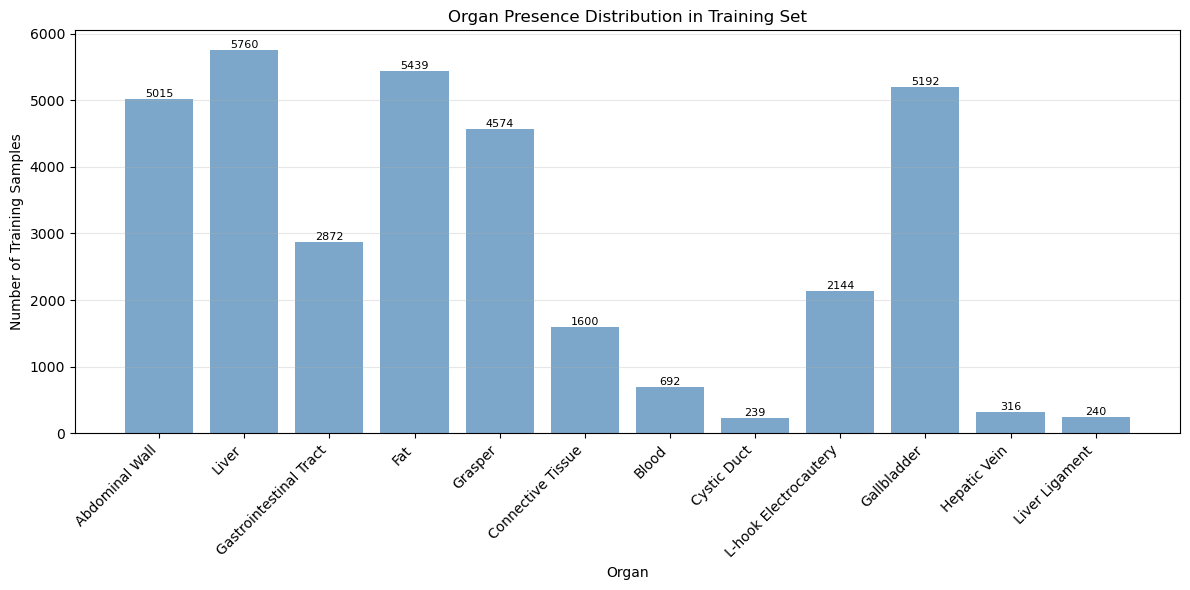

In [9]:
# Analyze organ distribution
organ_counts = Y.sum(axis=0)
total_samples = Y.shape[0]

print("📊 Organ presence statistics in training set:")
for i, class_id in enumerate(LABEL_IDS):
    organ_name = ID2LABEL[class_id]
    count = organ_counts[i]
    percentage = (count / total_samples) * 100
    print(f"  {organ_name:25} {count:5d} samples ({percentage:5.1f}%)")

# Visualize distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
organ_names = [ID2LABEL[cid] for cid in LABEL_IDS]
x = np.arange(len(organ_names))
bars = ax.bar(x, organ_counts, color='steelblue', alpha=0.7)
ax.set_xlabel('Organ')
ax.set_ylabel('Number of Training Samples')
ax.set_title('Organ Presence Distribution in Training Set')
ax.set_xticks(x)
ax.set_xticklabels(organ_names, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, organ_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Select Balanced Test Set

In [10]:
def select_balanced_test_set(Y, n_select, seed=42):
    """Select a balanced subset that maximizes representation of all organs."""
    np.random.seed(seed)
    n_samples, n_classes = Y.shape
    
    # Start with samples that have rare organs
    organ_counts = Y.sum(axis=0)
    selected_indices = set()
    selected_mask = np.zeros(n_samples, dtype=bool)
    
    # Greedy selection: prioritize underrepresented organs
    while len(selected_indices) < n_select:
        # Calculate current representation
        if len(selected_indices) > 0:
            current_counts = Y[list(selected_indices)].sum(axis=0)
        else:
            current_counts = np.zeros(n_classes)
        
        # Calculate representation ratio
        target_ratio = n_select / n_samples
        expected_counts = organ_counts * target_ratio
        deficit = expected_counts - current_counts
        
        # Find samples that help most with underrepresented organs
        scores = np.zeros(n_samples)
        for i in range(n_samples):
            if i not in selected_indices:
                # Score based on how much this sample helps underrepresented organs
                contribution = Y[i] * deficit
                scores[i] = contribution.sum()
        
        # Select sample with highest score
        # Add randomness for ties
        scores[list(selected_indices)] = -np.inf
        top_k = min(10, n_samples - len(selected_indices))
        top_indices = np.argpartition(scores, -top_k)[-top_k:]
        chosen_idx = np.random.choice(top_indices)
        selected_indices.add(chosen_idx)
    
    return sorted(list(selected_indices))

# Select balanced test set
print(f"\n🎯 Selecting {CONFIG['n_test_samples']} balanced test samples...")

balanced_file = CONFIG["output_dir"] / f"balanced_test_indices_{CONFIG['n_test_samples']}.json"

if balanced_file.exists():
    print(f"Loading existing balanced indices from {balanced_file.name}")
    with open(balanced_file, 'r') as f:
        balanced_indices = json.load(f)['indices']
else:
    balanced_indices = select_balanced_test_set(Y, CONFIG['n_test_samples'], CONFIG['seed'])
    
    # Save indices
    with open(balanced_file, 'w') as f:
        json.dump({'indices': balanced_indices, 'seed': CONFIG['seed']}, f, indent=2)
    print(f"Saved balanced indices to {balanced_file.name}")

# Analyze balance
Y_balanced = Y[balanced_indices]
balanced_counts = Y_balanced.sum(axis=0)

print("\nBalanced test set organ distribution:")
for i, class_id in enumerate(LABEL_IDS):
    organ_name = ID2LABEL[class_id]
    count = balanced_counts[i]
    percentage = (count / CONFIG['n_test_samples']) * 100
    print(f"  {organ_name:25} {count:3d} samples ({percentage:5.1f}%)")


🎯 Selecting 100 balanced test samples...
Loading existing balanced indices from balanced_test_indices_100.json

Balanced test set organ distribution:
  Abdominal Wall             92 samples ( 92.0%)
  Liver                     100 samples (100.0%)
  Gastrointestinal Tract     55 samples ( 55.0%)
  Fat                       100 samples (100.0%)
  Grasper                    84 samples ( 84.0%)
  Connective Tissue          36 samples ( 36.0%)
  Blood                      11 samples ( 11.0%)
  Cystic Duct                 7 samples (  7.0%)
  L-hook Electrocautery      41 samples ( 41.0%)
  Gallbladder                94 samples ( 94.0%)
  Hepatic Vein                6 samples (  6.0%)
  Liver Ligament              4 samples (  4.0%)


## Helper Functions for Few-Shot Selection

In [11]:
def find_adjacent_organs(lab_t: torch.Tensor, target_class_id: int, 
                         distance_threshold: int = 50) -> List[int]:
    """Find organs that are adjacent to the target organ."""
    # Create mask for target organ
    target_mask = (lab_t == target_class_id).cpu().numpy()
    
    if not target_mask.any():
        return []
    
    # Dilate target mask to find nearby regions
    dilated = ndimage.binary_dilation(target_mask, iterations=distance_threshold)
    
    # Find what other organs are in the dilated region
    adjacent_organs = []
    for class_id in LABEL_IDS:
        if class_id == target_class_id:
            continue
        organ_mask = (lab_t == class_id).cpu().numpy()
        if organ_mask.any() and (organ_mask & dilated).any():
            adjacent_organs.append(class_id)
    
    return adjacent_organs

def sample_wrong_bbox_from_adjacent(lab_t: torch.Tensor, target_class_id: int, 
                                   adjacent_class_id: int) -> Optional[Tuple[int, int, int, int]]:
    """Get bounding box of an adjacent organ (wrong answer for target organ)."""
    mask = (lab_t == adjacent_class_id).cpu().numpy()
    
    if not mask.any():
        return None
    
    rows, cols = np.where(mask)
    y1, y2 = rows.min(), rows.max()
    x1, x2 = cols.min(), cols.max()
    
    return (int(x1), int(y1), int(x2), int(y2))

def sample_shifted_bbox(true_bbox: Tuple[int, int, int, int], 
                       image_shape: Tuple[int, int],
                       shift_factor: float = 0.5) -> Tuple[int, int, int, int]:
    """Create a shifted/wrong bounding box based on the true bbox."""
    x1, y1, x2, y2 = true_bbox
    width = x2 - x1
    height = y2 - y1
    H, W = image_shape
    
    # Random shift direction
    direction = random.choice(['left', 'right', 'up', 'down'])
    
    if direction == 'left':
        shift_x = -int(width * shift_factor)
        shift_y = random.randint(-height//4, height//4)
    elif direction == 'right':
        shift_x = int(width * shift_factor)
        shift_y = random.randint(-height//4, height//4)
    elif direction == 'up':
        shift_x = random.randint(-width//4, width//4)
        shift_y = -int(height * shift_factor)
    else:  # down
        shift_x = random.randint(-width//4, width//4)
        shift_y = int(height * shift_factor)
    
    # Apply shift and clip to image bounds
    new_x1 = max(0, min(W - width, x1 + shift_x))
    new_y1 = max(0, min(H - height, y1 + shift_y))
    new_x2 = min(W - 1, new_x1 + width)
    new_y2 = min(H - 1, new_y1 + height)
    
    return (int(new_x1), int(new_y1), int(new_x2), int(new_y2))

## Build Few-Shot Plans for Pointing Task

In [12]:
def build_pointing_fewshot_plan(dataset, Y, balanced_indices, config):
    """Build few-shot examples for pointing task."""
    np.random.seed(config['seed'] + 1)
    random.seed(config['seed'] + 1)
    
    n_train = dataset.total('train')
    plan = {'split': 'train', 'plan': {}}
    
    # Exclude test samples from selection pool
    excluded = set(balanced_indices)
    available_indices = [i for i in range(n_train) if i not in excluded]
    
    for class_idx, class_id in enumerate(LABEL_IDS):
        organ_name = ID2LABEL[class_id]
        print(f"\nProcessing {organ_name}...")
        
        # Find positive and negative samples
        pos_indices = [i for i in available_indices if Y[i, class_idx] == 1]
        neg_indices = [i for i in available_indices if Y[i, class_idx] == 0]
        
        organ_info = {
            'name': organ_name,
            'class_id': int(class_id),
            'pos_available': len(pos_indices),
            'neg_available': len(neg_indices),
            'positives': [],
            'negatives_absent': [],
            'negatives_wrong_point': []
        }
        
        # Select positive examples with correct points
        if len(pos_indices) > 0:
            selected_pos = np.random.choice(pos_indices, 
                                          min(config['n_pos_examples'], len(pos_indices)), 
                                          replace=False)
            for idx in selected_pos:
                example = dataset.get_example('train', idx)
                img_t, lab_t = dataset.example_to_tensors(example)
                point = dataset.sample_point_in_mask(lab_t, class_id, strategy='centroid')
                if point:
                    organ_info['positives'].append({
                        'idx': int(idx),
                        'point': point,
                        'frame_id': example['frame_id']
                    })
        
        # Select negative examples where organ is absent
        if len(neg_indices) > 0:
            selected_neg = np.random.choice(neg_indices,
                                          min(config['n_neg_absent'], len(neg_indices)),
                                          replace=False)
            for idx in selected_neg:
                example = dataset.get_example('train', idx)
                organ_info['negatives_absent'].append({
                    'idx': int(idx),
                    'point': None,
                    'frame_id': example['frame_id']
                })
        
        # Select negative examples with wrong points (near-miss)
        if len(pos_indices) > 0:
            # Use different positive samples for wrong points
            remaining_pos = [i for i in pos_indices if i not in selected_pos]
            if len(remaining_pos) > 0:
                selected_wrong = np.random.choice(remaining_pos,
                                                min(config['n_neg_wrong'], len(remaining_pos)),
                                                replace=False)
                for idx in selected_wrong:
                    example = dataset.get_example('train', idx)
                    img_t, lab_t = dataset.example_to_tensors(example)
                    
                    # Find adjacent organs
                    adjacent = find_adjacent_organs(lab_t, class_id)
                    
                    wrong_point = None
                    if adjacent:
                        # Sample point from adjacent organ
                        adj_class = random.choice(adjacent)
                        wrong_point = dataset.sample_point_in_mask(lab_t, adj_class, strategy='centroid')
                    
                    if wrong_point is None:
                        # Create near-miss point by shifting from true point
                        true_point = dataset.sample_point_in_mask(lab_t, class_id, strategy='centroid')
                        if true_point:
                            H, W = lab_t.shape
                            shift_dist = random.randint(30, 100)
                            angle = random.uniform(0, 2 * np.pi)
                            shift_x = int(shift_dist * np.cos(angle))
                            shift_y = int(shift_dist * np.sin(angle))
                            wrong_x = max(0, min(W-1, true_point[0] + shift_x))
                            wrong_y = max(0, min(H-1, true_point[1] + shift_y))
                            wrong_point = (wrong_x, wrong_y)
                    
                    if wrong_point:
                        organ_info['negatives_wrong_point'].append({
                            'idx': int(idx),
                            'point': wrong_point,
                            'frame_id': example['frame_id'],
                            'note': 'wrong_location'
                        })
        
        plan['plan'][str(class_id)] = organ_info
    
    return plan

# Build pointing few-shot plan
print("\n🎯 Building few-shot plan for POINTING task...")

pointing_plan_file = CONFIG["output_dir"] / f"fewshot_plan_pointing_{CONFIG['n_test_samples']}.json"

if pointing_plan_file.exists():
    print(f"Loading existing plan from {pointing_plan_file.name}")
    with open(pointing_plan_file, 'r') as f:
        pointing_plan = json.load(f)
else:
    pointing_plan = build_pointing_fewshot_plan(dataset, Y, balanced_indices, CONFIG)
    
    # Save plan
    with open(pointing_plan_file, 'w') as f:
        json.dump(pointing_plan, f, indent=2)
    print(f"Saved pointing plan to {pointing_plan_file.name}")

# Print summary
print("\nPointing plan summary:")
for class_id_str, info in pointing_plan['plan'].items():
    name = info['name']
    n_pos = len(info['positives'])
    n_neg_absent = len(info['negatives_absent'])
    n_neg_wrong = len(info['negatives_wrong_point'])
    print(f"  {name:25} pos={n_pos}, neg_absent={n_neg_absent}, neg_wrong={n_neg_wrong}")


🎯 Building few-shot plan for POINTING task...

Processing Abdominal Wall...

Processing Liver...

Processing Gastrointestinal Tract...

Processing Fat...

Processing Grasper...

Processing Connective Tissue...

Processing Blood...

Processing Cystic Duct...

Processing L-hook Electrocautery...

Processing Gallbladder...

Processing Hepatic Vein...

Processing Liver Ligament...
Saved pointing plan to fewshot_plan_pointing_100.json

Pointing plan summary:
  Abdominal Wall            pos=1, neg_absent=1, neg_wrong=1
  Liver                     pos=1, neg_absent=0, neg_wrong=1
  Gastrointestinal Tract    pos=1, neg_absent=1, neg_wrong=1
  Fat                       pos=1, neg_absent=1, neg_wrong=1
  Grasper                   pos=1, neg_absent=1, neg_wrong=1
  Connective Tissue         pos=1, neg_absent=1, neg_wrong=1
  Blood                     pos=1, neg_absent=1, neg_wrong=1
  Cystic Duct               pos=1, neg_absent=1, neg_wrong=1
  L-hook Electrocautery     pos=1, neg_absent=1, neg_

## Build Few-Shot Plans for Bounding Box Task

In [13]:
def build_bbox_fewshot_plan(dataset, Y, balanced_indices, config):
    """Build few-shot examples for bounding box task."""
    np.random.seed(config['seed'] + 2)
    random.seed(config['seed'] + 2)
    
    n_train = dataset.total('train')
    plan = {'split': 'train', 'plan': {}}
    
    # Exclude test samples from selection pool
    excluded = set(balanced_indices)
    available_indices = [i for i in range(n_train) if i not in excluded]
    
    for class_idx, class_id in enumerate(LABEL_IDS):
        organ_name = ID2LABEL[class_id]
        print(f"\nProcessing {organ_name}...")
        
        # Find positive and negative samples
        pos_indices = [i for i in available_indices if Y[i, class_idx] == 1]
        neg_indices = [i for i in available_indices if Y[i, class_idx] == 0]
        
        organ_info = {
            'name': organ_name,
            'class_id': int(class_id),
            'pos_available': len(pos_indices),
            'neg_available': len(neg_indices),
            'positives': [],
            'negatives_absent': [],
            'negatives_wrong_bbox': []
        }
        
        # (1) Positive examples: correct bounding boxes
        if len(pos_indices) > 0:
            selected_pos = np.random.choice(pos_indices,
                                          min(config['n_pos_examples'], len(pos_indices)),
                                          replace=False)
            for idx in selected_pos:
                example = dataset.get_example('train', idx)
                img_t, lab_t = dataset.example_to_tensors(example)
                
                # Get bounding boxes for this organ
                bboxes = dataset.get_bounding_boxes(lab_t, class_id, min_pixels=config['min_pixels'])
                if class_id in bboxes and len(bboxes[class_id]) > 0:
                    # Store all bboxes (for disconnected segments)
                    organ_info['positives'].append({
                        'idx': int(idx),
                        'bboxes': bboxes[class_id],  # List of (x1,y1,x2,y2) tuples
                        'frame_id': example['frame_id']
                    })
        
        # (2) Negative example 1: organ is absent
        if len(neg_indices) > 0:
            selected_neg = np.random.choice(neg_indices,
                                          min(config['n_neg_absent'], len(neg_indices)),
                                          replace=False)
            for idx in selected_neg:
                example = dataset.get_example('train', idx)
                organ_info['negatives_absent'].append({
                    'idx': int(idx),
                    'bboxes': None,  # No bbox since organ is absent
                    'frame_id': example['frame_id']
                })
        
        # (3) Negative example 2: wrong bbox (adjacent organ or shifted)
        if len(pos_indices) > 0:
            # Use different positive samples for wrong bboxes
            remaining_pos = [i for i in pos_indices if i not in selected_pos]
            if len(remaining_pos) > 0:
                n_wrong_needed = config['n_neg_wrong']
                # If no absent examples, add one more wrong bbox example
                if len(neg_indices) == 0:
                    n_wrong_needed += 1
                
                selected_wrong = np.random.choice(remaining_pos,
                                                min(n_wrong_needed, len(remaining_pos)),
                                                replace=False)
                for idx in selected_wrong:
                    example = dataset.get_example('train', idx)
                    img_t, lab_t = dataset.example_to_tensors(example)
                    
                    # Get true bbox for reference
                    true_bboxes = dataset.get_bounding_boxes(lab_t, class_id, min_pixels=config['min_pixels'])
                    
                    if class_id not in true_bboxes or len(true_bboxes[class_id]) == 0:
                        continue
                    
                    # Find adjacent organs
                    adjacent = find_adjacent_organs(lab_t, class_id)
                    
                    wrong_bboxes = None
                    wrong_type = 'unknown'
                    
                    if adjacent:
                        # Use bbox of adjacent organ
                        adj_class = random.choice(adjacent)
                        adj_bboxes = dataset.get_bounding_boxes(lab_t, adj_class, min_pixels=config['min_pixels'])
                        if adj_class in adj_bboxes and len(adj_bboxes[adj_class]) > 0:
                            wrong_bboxes = adj_bboxes[adj_class]
                            wrong_type = f'adjacent_{ID2LABEL[adj_class]}'
                    
                    if wrong_bboxes is None:
                        # Create shifted bbox
                        true_bbox = true_bboxes[class_id][0]  # Use first bbox
                        shifted_bbox = sample_shifted_bbox(true_bbox, lab_t.shape)
                        wrong_bboxes = [shifted_bbox]
                        wrong_type = 'shifted'
                    
                    organ_info['negatives_wrong_bbox'].append({
                        'idx': int(idx),
                        'bboxes': wrong_bboxes,
                        'frame_id': example['frame_id'],
                        'wrong_type': wrong_type
                    })
        
        plan['plan'][str(class_id)] = organ_info
    
    return plan

# Build bounding box few-shot plan
print("\n📦 Building few-shot plan for BOUNDING BOX task...")

bbox_plan_file = CONFIG["output_dir"] / f"fewshot_plan_bbox_{CONFIG['n_test_samples']}.json"

if bbox_plan_file.exists():
    print(f"Loading existing plan from {bbox_plan_file.name}")
    with open(bbox_plan_file, 'r') as f:
        bbox_plan = json.load(f)
else:
    bbox_plan = build_bbox_fewshot_plan(dataset, Y, balanced_indices, CONFIG)
    
    # Save plan
    with open(bbox_plan_file, 'w') as f:
        json.dump(bbox_plan, f, indent=2)
    print(f"Saved bbox plan to {bbox_plan_file.name}")

# Print summary
print("\nBounding box plan summary:")
for class_id_str, info in bbox_plan['plan'].items():
    name = info['name']
    n_pos = len(info['positives'])
    n_neg_absent = len(info['negatives_absent'])
    n_neg_wrong = len(info['negatives_wrong_bbox'])
    print(f"  {name:25} pos={n_pos}, neg_absent={n_neg_absent}, neg_wrong={n_neg_wrong}")


📦 Building few-shot plan for BOUNDING BOX task...

Processing Abdominal Wall...

Processing Liver...

Processing Gastrointestinal Tract...

Processing Fat...

Processing Grasper...

Processing Connective Tissue...

Processing Blood...

Processing Cystic Duct...

Processing L-hook Electrocautery...

Processing Gallbladder...

Processing Hepatic Vein...

Processing Liver Ligament...
Saved bbox plan to fewshot_plan_bbox_100.json

Bounding box plan summary:
  Abdominal Wall            pos=1, neg_absent=1, neg_wrong=1
  Liver                     pos=1, neg_absent=0, neg_wrong=2
  Gastrointestinal Tract    pos=1, neg_absent=1, neg_wrong=1
  Fat                       pos=1, neg_absent=1, neg_wrong=1
  Grasper                   pos=1, neg_absent=1, neg_wrong=1
  Connective Tissue         pos=1, neg_absent=1, neg_wrong=1
  Blood                     pos=1, neg_absent=1, neg_wrong=1
  Cystic Duct               pos=1, neg_absent=1, neg_wrong=1
  L-hook Electrocautery     pos=1, neg_absent=1, neg_

## Visualize Pointing Few-Shot Examples


📊 Visualizing pointing few-shot examples...


/tmp/ipykernel_13899/778879361.py:77: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_13899/778879361.py:77: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/opt/conda/envs/rapids/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/rapids/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


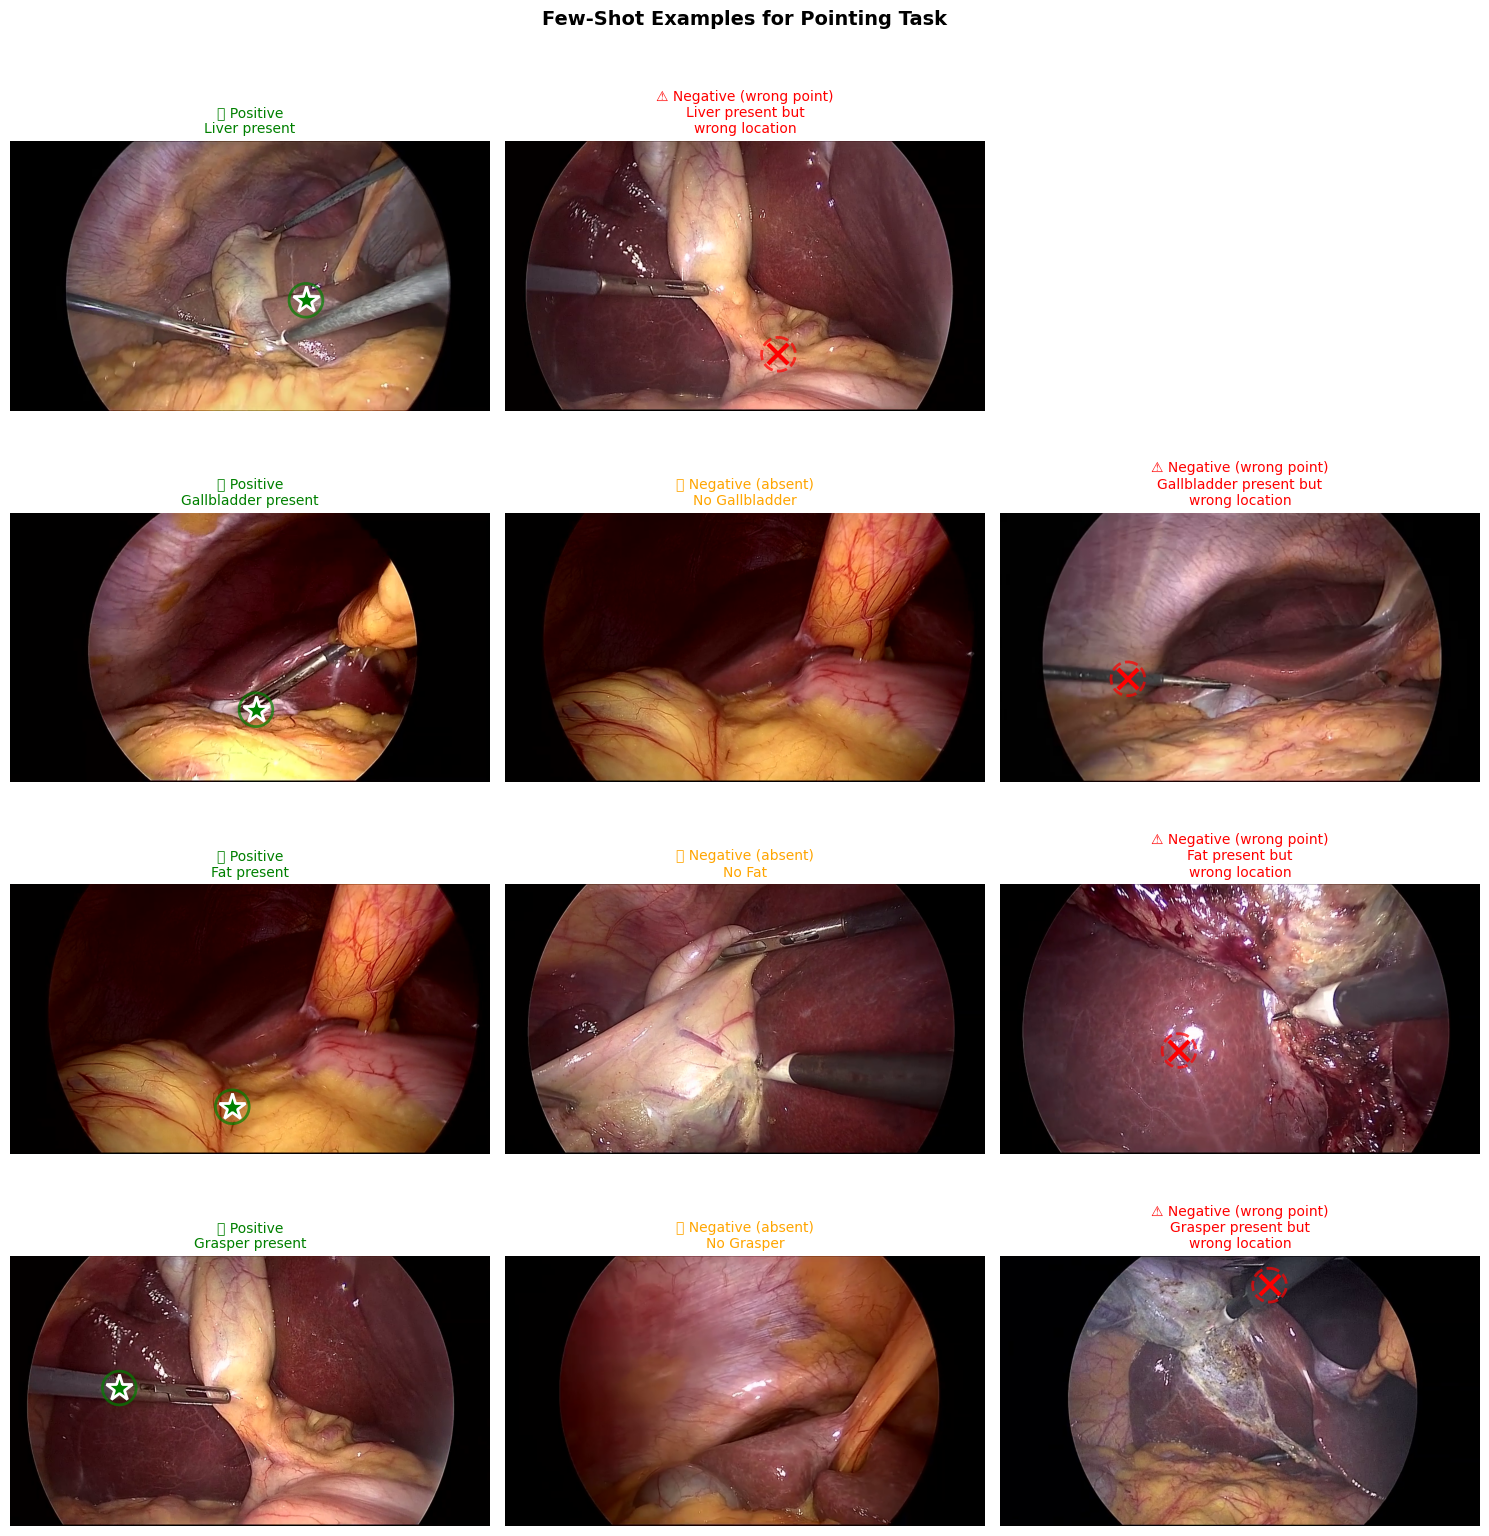

In [14]:
def visualize_pointing_examples(dataset, plan, organ_names_to_show=None, max_organs=4):
    """Visualize few-shot examples for pointing task."""
    
    if organ_names_to_show is None:
        # Show first few organs with examples
        organ_names_to_show = []
        for class_id_str, info in plan['plan'].items():
            if len(info['positives']) > 0:
                organ_names_to_show.append(info['name'])
                if len(organ_names_to_show) >= max_organs:
                    break
    
    n_organs = len(organ_names_to_show)
    fig = plt.figure(figsize=(15, 4 * n_organs))
    
    for organ_idx, organ_name in enumerate(organ_names_to_show):
        # Find organ info
        organ_info = None
        for class_id_str, info in plan['plan'].items():
            if info['name'] == organ_name:
                organ_info = info
                break
        
        if organ_info is None:
            continue
        
        # Plot positive example
        col_idx = 0
        if len(organ_info['positives']) > 0:
            ax = plt.subplot(n_organs, 3, organ_idx * 3 + col_idx + 1)
            pos_data = organ_info['positives'][0]
            example = dataset.get_example('train', pos_data['idx'])
            ax.imshow(example['image'])
            
            # Draw correct point
            if pos_data['point']:
                ax.plot(pos_data['point'][0], pos_data['point'][1], 'g*', 
                       markersize=20, markeredgewidth=2, markeredgecolor='white')
                circle = patches.Circle(pos_data['point'], 30, linewidth=2,
                                       edgecolor='green', facecolor='none', alpha=0.7)
                ax.add_patch(circle)
            
            ax.set_title(f"✅ Positive\n{organ_name} present", fontsize=10, color='green')
            ax.axis('off')
            col_idx += 1
        
        # Plot negative (absent) example
        if len(organ_info['negatives_absent']) > 0:
            ax = plt.subplot(n_organs, 3, organ_idx * 3 + col_idx + 1)
            neg_data = organ_info['negatives_absent'][0]
            example = dataset.get_example('train', neg_data['idx'])
            ax.imshow(example['image'])
            ax.set_title(f"❌ Negative (absent)\nNo {organ_name}", fontsize=10, color='orange')
            ax.axis('off')
            col_idx += 1
        
        # Plot negative (wrong point) example
        if len(organ_info['negatives_wrong_point']) > 0:
            ax = plt.subplot(n_organs, 3, organ_idx * 3 + col_idx + 1)
            wrong_data = organ_info['negatives_wrong_point'][0]
            example = dataset.get_example('train', wrong_data['idx'])
            ax.imshow(example['image'])
            
            # Draw wrong point
            if wrong_data['point']:
                ax.plot(wrong_data['point'][0], wrong_data['point'][1], 'rx',
                       markersize=15, markeredgewidth=3)
                circle = patches.Circle(wrong_data['point'], 30, linewidth=2,
                                       edgecolor='red', facecolor='none', alpha=0.7, linestyle='--')
                ax.add_patch(circle)
            
            ax.set_title(f"⚠️ Negative (wrong point)\n{organ_name} present but\nwrong location", 
                        fontsize=10, color='red')
            ax.axis('off')
    
    plt.suptitle("Few-Shot Examples for Pointing Task", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize examples
print("\n📊 Visualizing pointing few-shot examples...")
visualize_pointing_examples(dataset, pointing_plan, 
                           organ_names_to_show=['Liver', 'Gallbladder', 'Fat', 'Grasper'],
                           max_organs=4)

## Visualize Bounding Box Few-Shot Examples


📦 Visualizing bounding box few-shot examples...


/tmp/ipykernel_13899/2148317584.py:80: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_13899/2148317584.py:80: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


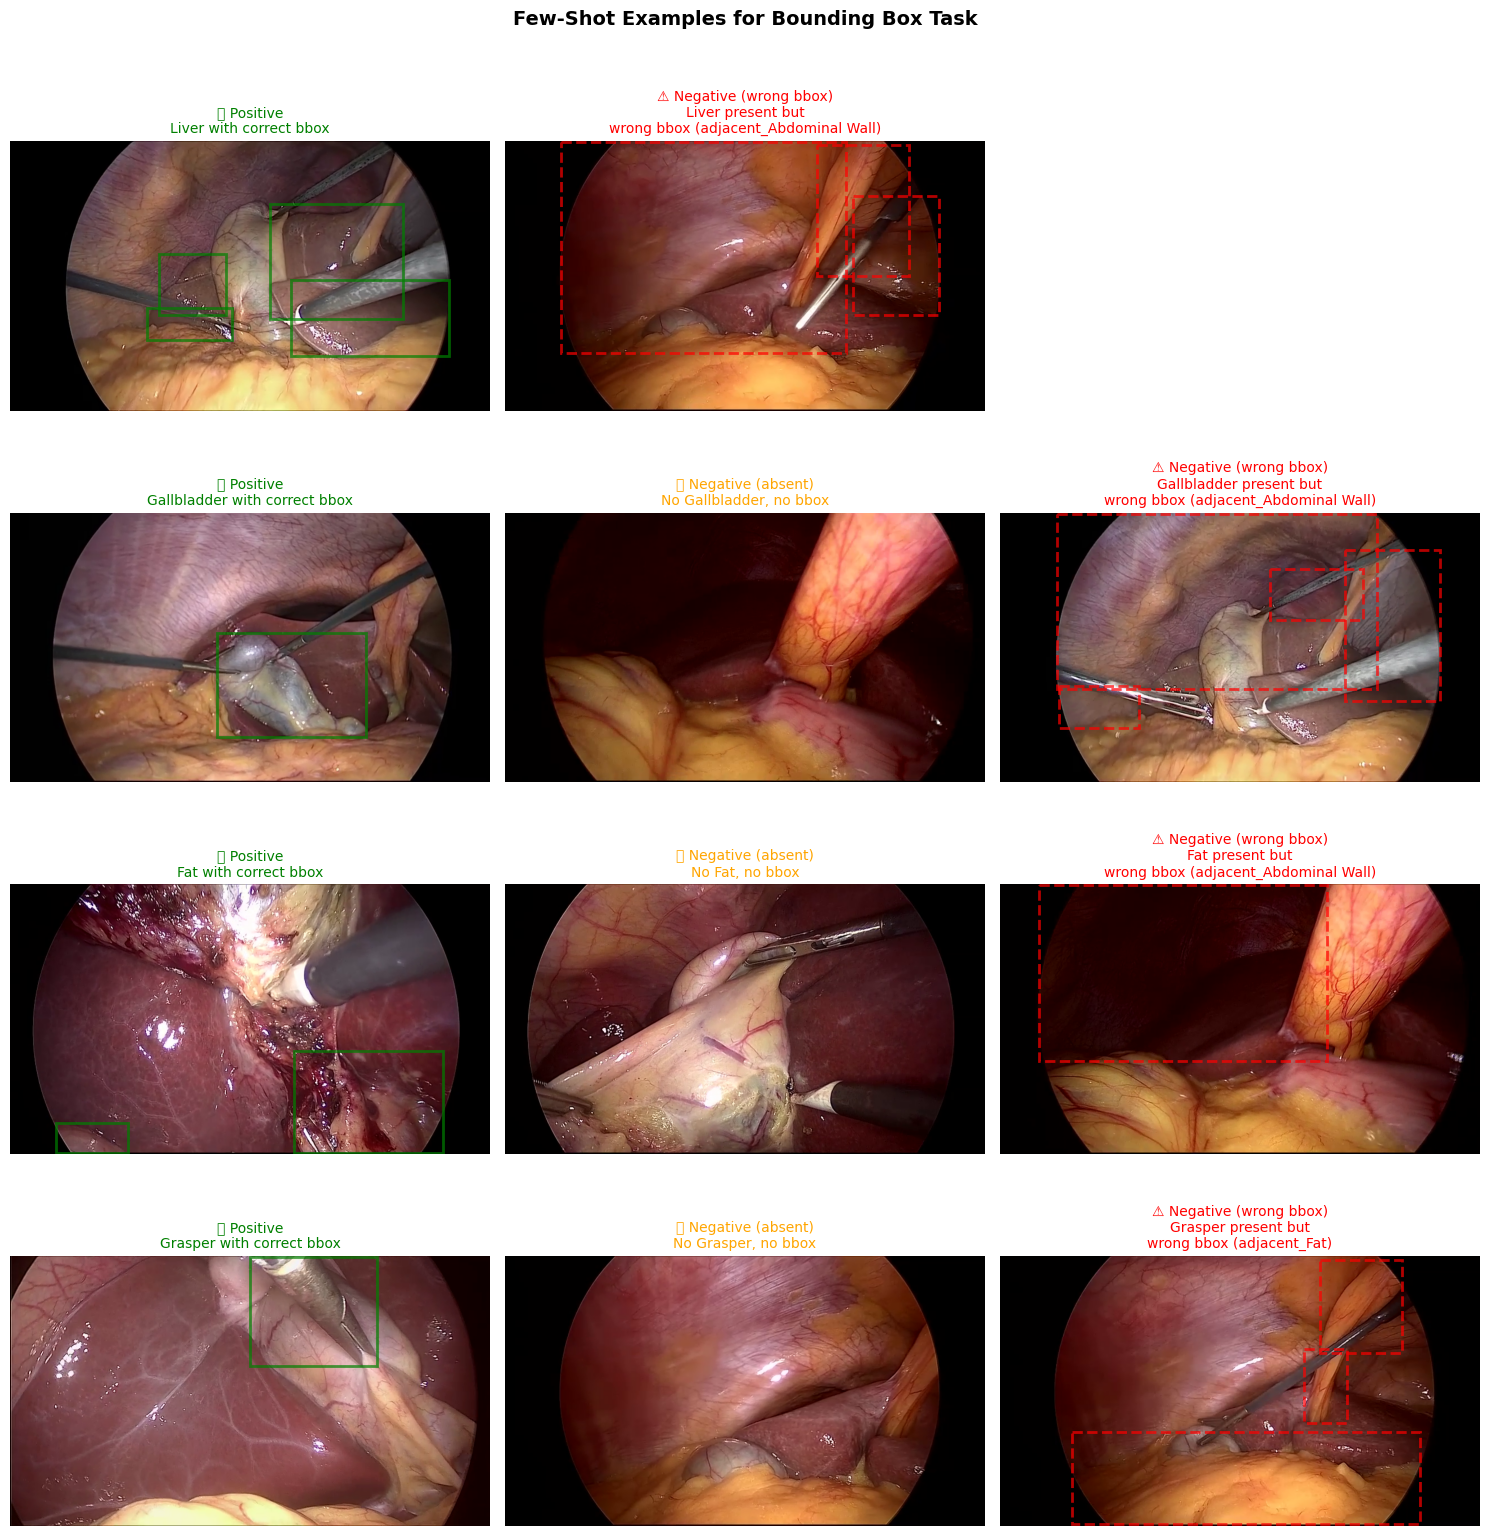

In [15]:
def visualize_bbox_examples(dataset, plan, organ_names_to_show=None, max_organs=4):
    """Visualize few-shot examples for bounding box task."""
    
    if organ_names_to_show is None:
        # Show first few organs with examples
        organ_names_to_show = []
        for class_id_str, info in plan['plan'].items():
            if len(info['positives']) > 0:
                organ_names_to_show.append(info['name'])
                if len(organ_names_to_show) >= max_organs:
                    break
    
    n_organs = len(organ_names_to_show)
    fig = plt.figure(figsize=(15, 4 * n_organs))
    
    for organ_idx, organ_name in enumerate(organ_names_to_show):
        # Find organ info
        organ_info = None
        for class_id_str, info in plan['plan'].items():
            if info['name'] == organ_name:
                organ_info = info
                break
        
        if organ_info is None:
            continue
        
        # Plot positive example
        col_idx = 0
        if len(organ_info['positives']) > 0:
            ax = plt.subplot(n_organs, 3, organ_idx * 3 + col_idx + 1)
            pos_data = organ_info['positives'][0]
            example = dataset.get_example('train', pos_data['idx'])
            ax.imshow(example['image'])
            
            # Draw correct bboxes
            if pos_data['bboxes']:
                for bbox in pos_data['bboxes']:
                    x1, y1, x2, y2 = bbox
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                            linewidth=2, edgecolor='green', 
                                            facecolor='none', alpha=0.7)
                    ax.add_patch(rect)
            
            ax.set_title(f"✅ Positive\n{organ_name} with correct bbox", fontsize=10, color='green')
            ax.axis('off')
            col_idx += 1
        
        # Plot negative (absent) example
        if len(organ_info['negatives_absent']) > 0:
            ax = plt.subplot(n_organs, 3, organ_idx * 3 + col_idx + 1)
            neg_data = organ_info['negatives_absent'][0]
            example = dataset.get_example('train', neg_data['idx'])
            ax.imshow(example['image'])
            ax.set_title(f"❌ Negative (absent)\nNo {organ_name}, no bbox", fontsize=10, color='orange')
            ax.axis('off')
            col_idx += 1
        
        # Plot negative (wrong bbox) example
        if len(organ_info['negatives_wrong_bbox']) > 0:
            ax = plt.subplot(n_organs, 3, organ_idx * 3 + col_idx + 1)
            wrong_data = organ_info['negatives_wrong_bbox'][0]
            example = dataset.get_example('train', wrong_data['idx'])
            ax.imshow(example['image'])
            
            # Draw wrong bboxes
            if wrong_data['bboxes']:
                for bbox in wrong_data['bboxes']:
                    x1, y1, x2, y2 = bbox
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                            linewidth=2, edgecolor='red',
                                            facecolor='none', alpha=0.7, linestyle='--')
                    ax.add_patch(rect)
            
            wrong_type = wrong_data.get('wrong_type', 'unknown')
            ax.set_title(f"⚠️ Negative (wrong bbox)\n{organ_name} present but\nwrong bbox ({wrong_type})",
                        fontsize=10, color='red')
            ax.axis('off')
    
    plt.suptitle("Few-Shot Examples for Bounding Box Task", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize examples
print("\n📦 Visualizing bounding box few-shot examples...")
visualize_bbox_examples(dataset, bbox_plan,
                       organ_names_to_show=['Liver', 'Gallbladder', 'Fat', 'Grasper'],
                       max_organs=4)

## Summary Statistics


✓ Statistics saved to: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholecseg8k_local/fewshot_statistics_local.png


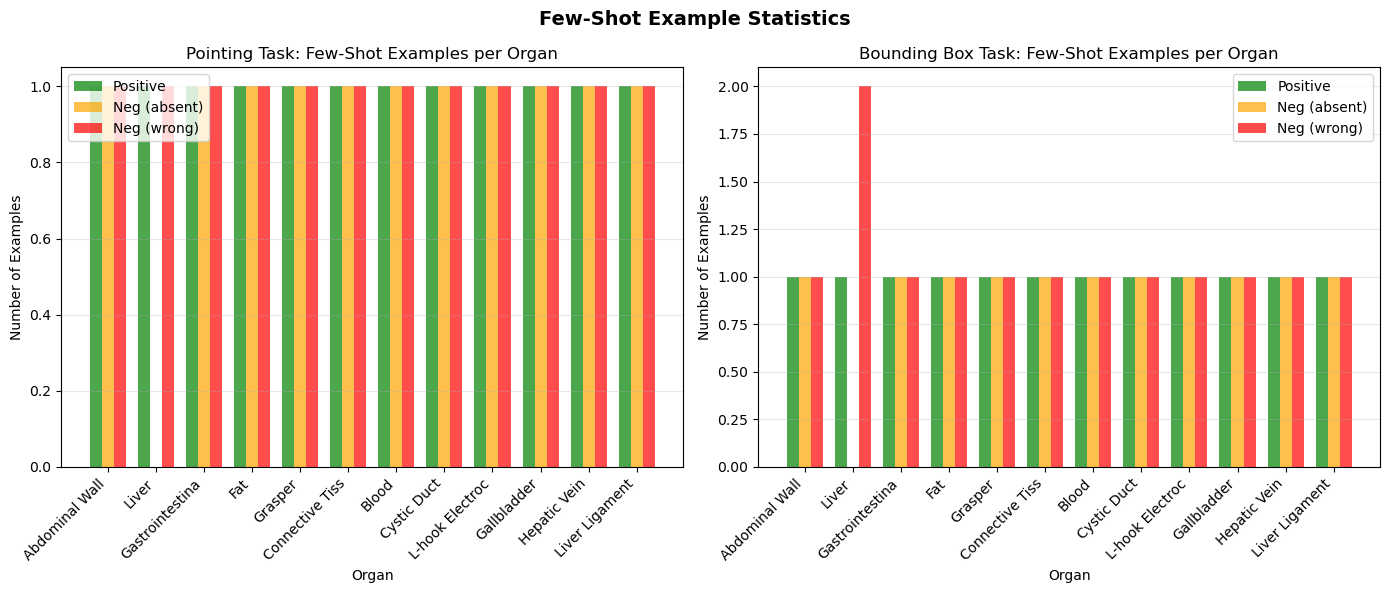

In [16]:
# Create summary statistics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Pointing task statistics
ax = axes[0]
organ_names_short = [name[:15] for name in [info['name'] for info in pointing_plan['plan'].values()]]
pos_counts = [len(info['positives']) for info in pointing_plan['plan'].values()]
neg_absent_counts = [len(info['negatives_absent']) for info in pointing_plan['plan'].values()]
neg_wrong_counts = [len(info['negatives_wrong_point']) for info in pointing_plan['plan'].values()]

x = np.arange(len(organ_names_short))
width = 0.25

bars1 = ax.bar(x - width, pos_counts, width, label='Positive', color='green', alpha=0.7)
bars2 = ax.bar(x, neg_absent_counts, width, label='Neg (absent)', color='orange', alpha=0.7)
bars3 = ax.bar(x + width, neg_wrong_counts, width, label='Neg (wrong)', color='red', alpha=0.7)

ax.set_xlabel('Organ')
ax.set_ylabel('Number of Examples')
ax.set_title('Pointing Task: Few-Shot Examples per Organ')
ax.set_xticks(x)
ax.set_xticklabels(organ_names_short, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Bounding box task statistics
ax = axes[1]
pos_counts_bbox = [len(info['positives']) for info in bbox_plan['plan'].values()]
neg_absent_counts_bbox = [len(info['negatives_absent']) for info in bbox_plan['plan'].values()]
neg_wrong_counts_bbox = [len(info['negatives_wrong_bbox']) for info in bbox_plan['plan'].values()]

bars1 = ax.bar(x - width, pos_counts_bbox, width, label='Positive', color='green', alpha=0.7)
bars2 = ax.bar(x, neg_absent_counts_bbox, width, label='Neg (absent)', color='orange', alpha=0.7)
bars3 = ax.bar(x + width, neg_wrong_counts_bbox, width, label='Neg (wrong)', color='red', alpha=0.7)

ax.set_xlabel('Organ')
ax.set_ylabel('Number of Examples')
ax.set_title('Bounding Box Task: Few-Shot Examples per Organ')
ax.set_xticks(x)
ax.set_xticklabels(organ_names_short, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Few-Shot Example Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save figure
stats_path = CONFIG["output_dir"] / "fewshot_statistics_local.png"
plt.savefig(stats_path, dpi=100, bbox_inches='tight')
print(f"\n✓ Statistics saved to: {stats_path}")

plt.show()

## Final Summary

In [17]:
print("\n" + "="*60)
print("✨ Few-shot example preparation complete!")
print("="*60)

print(f"\nFiles created in {CONFIG['output_dir']}:")
print(f"  1. Balanced test set: balanced_test_indices_{CONFIG['n_test_samples']}.json")
print(f"     - {CONFIG['n_test_samples']} balanced samples for evaluation")
print(f"  2. Pointing task plan: fewshot_plan_pointing_{CONFIG['n_test_samples']}.json")
print(f"     - Positive: correct point on organ")
print(f"     - Negative (absent): no organ present")
print(f"     - Negative (wrong): organ present but wrong location")
print(f"  3. Bounding box task plan: fewshot_plan_bbox_{CONFIG['n_test_samples']}.json")
print(f"     - Positive: correct bounding box(es)")
print(f"     - Negative (absent): no organ present")
print(f"     - Negative (wrong): organ present but wrong bbox (adjacent organ or shifted)")

print("\n📌 Key features:")
print("  • Video-based splits ensure no data leakage")
print("  • Balanced test set maximizes organ representation")
print("  • Multiple negative types test different failure modes")
print("  • Supports disconnected organ segments (multiple bboxes)")

print("\nNext steps:")
print("  1. Use these examples to evaluate LLM models")
print("  2. Compare zero-shot vs few-shot performance")
print("  3. Analyze which negative types are most challenging")


✨ Few-shot example preparation complete!

Files created in /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholecseg8k_local:
  1. Balanced test set: balanced_test_indices_100.json
     - 100 balanced samples for evaluation
  2. Pointing task plan: fewshot_plan_pointing_100.json
     - Positive: correct point on organ
     - Negative (absent): no organ present
     - Negative (wrong): organ present but wrong location
  3. Bounding box task plan: fewshot_plan_bbox_100.json
     - Positive: correct bounding box(es)
     - Negative (absent): no organ present
     - Negative (wrong): organ present but wrong bbox (adjacent organ or shifted)

📌 Key features:
  • Video-based splits ensure no data leakage
  • Balanced test set maximizes organ representation
  • Multiple negative types test different failure modes
  • Supports disconnected organ segments (multiple bboxes)

Next steps:
  1. Use these examples to evaluate LLM models
  2. Compare zero-shot vs few-shot performance
  3. Analyze wh